# Jupyter setup

### Import basic libraries

In [1]:
#import libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# web scraping
from bs4 import BeautifulSoup as bs
import re

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)

/home/andrasc/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/andrasc/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/andrasc/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.157 Safari/537.36",
    "Accept-Language": "en-GB,en-US;q=0.9,en;q=0.8,hu;q=0.7",
    "Referer": "https://google.com",
    "DNT": "1"
}

### Libraries for visuals

In [ ]:
!pip install seaborn numpy

In [3]:
import seaborn as sns

### Selenium setup for dynamic web scraping

In [5]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time

#Selenium setup
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument(f'user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36')

watchlist_driver = webdriver.Chrome(options=options)



### Libraries / programs for sentiment analysis

In [ ]:
!{sys.executable} -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

In [ ]:
!pip install transformers

In [5]:
import torch
print(torch.__version__)
import sys
print(sys.executable)
from transformers import pipeline

sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

2.8.0+cpu
/usr/bin/python3


Device set to use cpu


# Web scraping movie cards and urls

### Finding movie cards

In [7]:
# FIND THE MOVIE CARDS ON EVERY PAGE ON MY WATCHLIST
# runs for 98 seconds / 138 seconds
watchlist_driver = webdriver.Chrome(options=options)
page = 1
all_movie_cards =[]


while page <= 12 :  #change the number of the pages to 1 for testing purposes
  try:
    watchlist_url = f"https://www.imdb.com/user/ur40669107/watchlist/?ref_=hm_nv_urwls_all&page={page}"
    watchlist_driver.get(watchlist_url)

    watchlist_page_source = watchlist_driver.page_source
    # Scroll down the page to load all watchlist items
    last_height = watchlist_driver.execute_script("return document.body.scrollHeight")

    while True:
        watchlist_driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

        # Wait to load the new content
        time.sleep(1)

        new_height = watchlist_driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    watchlist_page_source = watchlist_driver.page_source

    soup = bs(watchlist_page_source, 'lxml')

    imdb_cards = soup.find_all('li', class_='ipc-metadata-list-summary-item')

    all_movie_cards.extend(imdb_cards)

    page +=1

  except Exception as e:
    print(f"Error on page {page}: {e}")
    break

print(f"Total movie cards found: {len(all_movie_cards)}")


Total movie cards found: 2973


In [8]:
#remove duplicates from movie cards list

unique_movie_cards = list(dict.fromkeys(all_movie_cards))
print(f"Total unique movie cards found: {len(unique_movie_cards)}")

Total unique movie cards found: 2723


### Titles and urls

In [9]:
#find the movie titles and separate links for the movies
imdb_movies = []
only_url = []

for movie in unique_movie_cards:
  title_link = movie.find('a', class_="ipc-title-link-wrapper")
  title = None
  if title_link:
    href = title_link.get('href')

    h3 = title_link.find('h3', class_="ipc-title__text ipc-title__text--reduced")
    title = h3.get_text(strip=True)

    title = re.sub(r'^\d+\.\s*', '', title)

    if href:
      full_url = "https://www.imdb.com" + href
      imdb_movies.append({
          'title': title,
          'url': full_url})
      only_url.append(full_url)

watchlist_movies_df = pd.DataFrame(imdb_movies)

In [10]:
print(f"Total unique movies found: {len(watchlist_movies_df)}")
print(f"Total unique urls found: {len(only_url)}")

Total unique movies found: 2723
Total unique urls found: 2723


In [15]:
#export the watchlist_movies_df
watchlist_movies_df.to_csv('watchlist_movies.csv', index=False)

### Information via the urls

In [21]:
from concurrent.futures import ThreadPoolExecutor, as_completed

In [41]:
# runs for 43 seconds for 100 titles
# runs for 201 seconds / 3.5 minutes for 500 titles
# runs for ??? for 1000 titles
# runs for roughly 20 minutes for 2700 titles
headers = {'User-Agent': 'Mozilla/5.0'}

def fetch_movie(url):
    current_movie_data = []
    try:
        response = requests.get(url, headers=headers, timeout=10)
        soup = bs(response.content, "lxml")

        # TITLE
        try:
            title_element = soup.find('h1', attrs={'data-testid': 'hero__pageTitle'})
            title = title_element.get_text(strip=True) if title_element else None
        except:
            title = None
        current_movie_data.append(title)

        # YEAR
        try:
            year_div = soup.find('ul', class_="ipc-inline-list ipc-inline-list--show-dividers sc-cb6a22b2-2 aFhKV baseAlt baseAlt")
            year_next_level = year_div.find('li', class_="ipc-inline-list__item")
            year = year_next_level.find('a').get_text(strip=True)
        except:
            year = None
        current_movie_data.append(year)

        # RATING
        try:
            rating_span = soup.find('span', class_="sc-4dc495c1-1 lbQcRY")
            rating = rating_span.get_text(strip=True) if rating_span else None
        except:
            rating = None
        current_movie_data.append(rating)

        # SHORT PLOT
        try:
            plot = soup.find_all("span", class_="sc-bf30a0e-2 bRimta")
            plot_text = plot[0].get_text(strip=True) if plot else None
        except:
            plot_text = None
        current_movie_data.append(plot_text)

        # AI SUMMARY
        try:
            ai_summary = soup.find_all('div', class_='ipc-html-content-inner-div')
            summary_text = ai_summary[0].get_text(strip=True) if ai_summary else None
        except:
            summary_text = None
        current_movie_data.append(summary_text)

    except Exception as e:
        print(f"Error fetching {url}: {e}")
        current_movie_data = [None, None, None, None, None]

    return current_movie_data


# Run in parallel
all_movies = []
urls = only_url #[:500]  # adjust here (100, 2700, etc.)

with ThreadPoolExecutor(max_workers=20) as executor:  # 20 parallel requests
    futures = [executor.submit(fetch_movie, url) for url in urls]
    for future in as_completed(futures):
        all_movies.append(future.result())

print(f"Fetched {len(all_movies)} movies")

Fetched 2723 movies


In [ ]:
#create dataframe from the scraped data
summary_df = pd.DataFrame(all_movies, columns=['title', 'year','rating', 'plot', 'summary'])

In [43]:
#export summary_df
summary_df.to_csv('summary.csv', index=False)

# Basic observations and data cleaning

In [12]:
#import summary_df
summary_df = pd.read_csv('summary.csv', delimiter=',')

### Basic information

In [7]:
summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2723 entries, 0 to 2722
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   title    2723 non-null   object 
 1   year     2502 non-null   float64
 2   rating   2722 non-null   float64
 3   plot     2718 non-null   object 
 4   summary  2711 non-null   object 
dtypes: float64(2), object(3)
memory usage: 106.5+ KB


In [8]:
print(f"Total number of movies without year: {len(summary_df['title'][summary_df['year'] == 0])}")
print(f"Total number of movies with year null: {len(summary_df['year'][summary_df['year'].isnull()])}")
print(f"Total number of movies without rating: {len(summary_df['title'][summary_df['rating'].isnull()])}")
print(f"Total number of movies without plot: {len(summary_df['title'][summary_df['plot'].isnull()])}")
print(f"Total number of movies without summary: {len(summary_df['title'][summary_df['summary'].isnull()])}")
print(f"Total number of movies without title: {len(summary_df['title'][summary_df['title'].isnull()])}")

Total number of movies without year: 0
Total number of movies with year null: 221
Total number of movies without rating: 1
Total number of movies without plot: 5
Total number of movies without summary: 12
Total number of movies without title: 0


### Remove rows with missing data 

In [14]:
# Filter out rows where the year is 0
summary_df = summary_df[summary_df['year'] != 0]
summary_df = summary_df[summary_df['year'].isnull() == False]
summary_df = summary_df[summary_df['plot'].isnull() == False]
summary_df = summary_df[summary_df['summary'].isnull() == False]
print(len(summary_df))

2491


In [ ]:
summary_df.head()

In [16]:
summary_df['title'] = summary_df['title'].astype(str)
summary_df['year'] = summary_df['year'].astype(int)
summary_df['rating'] = summary_df['rating'].astype(float)
summary_df['summary'] = summary_df['summary'].astype(str)
summary_df['plot'] = summary_df['plot'].astype(str)

In [17]:
summary_df['rating'].describe()

count    2491.000000
mean        6.728302
std         0.908261
min         1.300000
25%         6.200000
50%         6.700000
75%         7.300000
max         9.300000
Name: rating, dtype: float64

### Adding 'era' and 'rate_bin' columns for better overview

In [18]:
#creating bins in the year column
min_year = summary_df['year'].min()
max_year = summary_df['year'].max()

bins = list(range(min_year, max_year, 25)) + [max_year]

labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]

summary_df['era'] = pd.cut(summary_df['year'], bins=bins, labels=labels, right=False)

summary_df.groupby('era').size()

/tmp/ipykernel_298542/3159515291.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_df.groupby('era').size()


era
1937-1962      17
1962-1987     126
1987-2012    1212
2012-2025    1108
dtype: int64

In [19]:
#creating bins in the rating column
bins = [0, 2.5, 5, 7.5, 10]

labels = ['0-2.5', '2.5-5', '5-7.5', '7.5-10']

summary_df['rate_bin'] = pd.cut(summary_df['rating'], bins=bins, labels=labels, right=False)

summary_df.groupby('rate_bin').size()

/tmp/ipykernel_298542/517420035.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_df.groupby('rate_bin').size()


rate_bin
0-2.5        2
2.5-5       74
5-7.5     1868
7.5-10     547
dtype: int64

# Basic df visualization

<Axes: xlabel='year', ylabel='rating'>

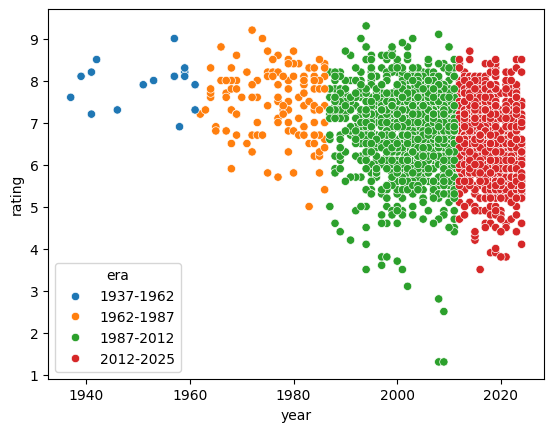

In [14]:
sns.scatterplot(data=summary_df, x='year', y='rating', hue= 'era')

In [ ]:
sns.relplot(data=summary_df,
            kind='line',
            x='year',
            y='plot_sentiment_score')

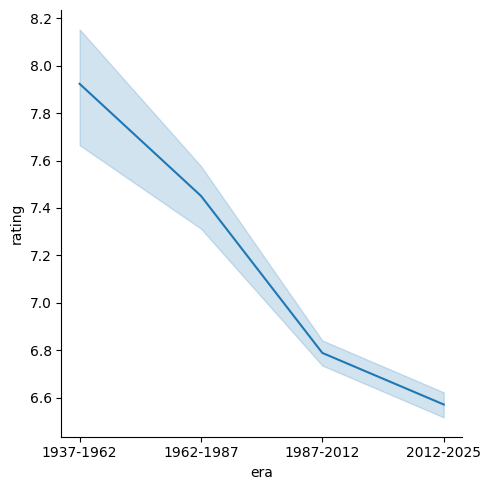

In [15]:
sns.relplot(data=summary_df,
            kind='line',
            x='era',
            y='rating')

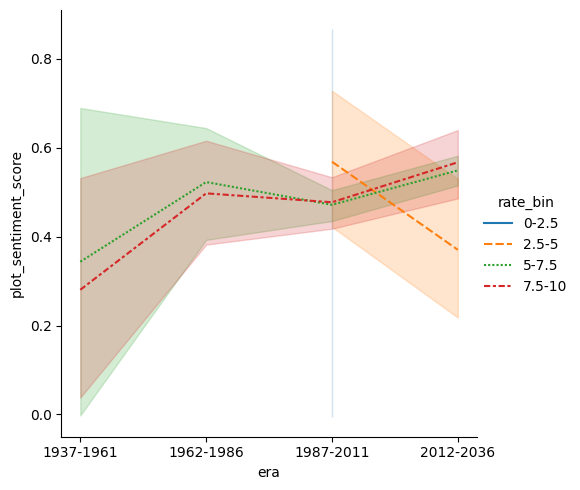

In [55]:
sns.relplot(data=summary_df,
            kind='line',
            x='era',
            y='plot_sentiment_score',
           style='rate_bin',
           hue='rate_bin')

Text(0.5, 1.03, 'Rating throughout the eras')

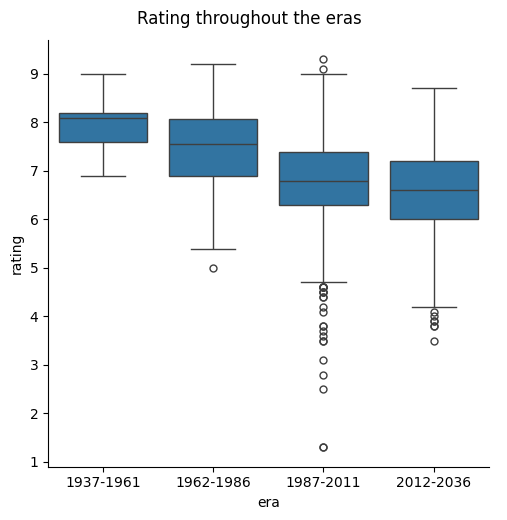

In [78]:
g = sns.catplot(data=summary_df,
                kind='box',
                x='era',
                y='rating')
g.fig.suptitle('Rating throughout the eras',
              y=1.03)

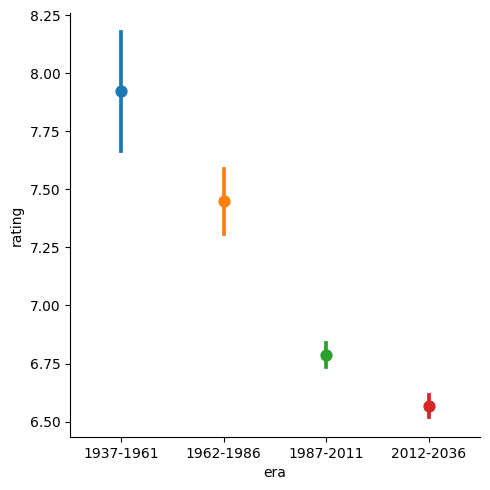

In [17]:
sns.catplot(data=summary_df,
            kind='point',
            x='era',
            y='rating',
            hue='era')

# Sentiment analysis

## Sentiment analyzer

### Analysis

In [22]:
# Define the maximum sequence length for the model
max_len = sentiment_analyzer.model.config.max_position_embeddings
print(max_len)

512


In [23]:
#APPLY THE SENT ANALYZER TO THE PLOT AND SUMMARY COLUMNS
#RUNNING FOR 10-15 minutes

def get_sentiment_score_in_chunks(text, max_len, sentiment_analyzer):
    """Analyzes sentiment of text in chunks and returns the average score."""
    chunks = [text[i:i + max_len] for i in range(0, len(text), max_len)]
    chunk_scores = []
    for chunk in chunks:
        result = sentiment_analyzer(chunk)
        score = result[0]['score'] if result[0]['label'] == 'POSITIVE' else -result[0]['score']
        chunk_scores.append(score)

    if not chunk_scores:
        return None  # Handle empty text case

    # Calculate the average score
    avg_score = sum(chunk_scores) / len(chunk_scores)
    return avg_score

def map_score_to_category(score):
    """Maps a sentiment score to one of 5 categories."""
    if score is None:
        return 'Unknown'
    elif score < -0.6: # Adjust the range based on the score calculation in the function above
        return 'Strongly Negative'
    elif score < -0.2:
        return 'Negative'
    elif score < 0.2:
        return 'Neutral'
    elif score < 0.6:
        return 'Positive'
    else:
        return 'Strongly Positive'


# Create sentiment results separately
plot_sentiment_score = summary_df['plot'].apply(
    lambda x: get_sentiment_score_in_chunks(x, max_len, sentiment_analyzer)
)

plot_sentiment_category = plot_sentiment_score.apply(map_score_to_category)

summary_sentiment_score = summary_df['summary'].apply(
    lambda x: get_sentiment_score_in_chunks(x, max_len, sentiment_analyzer)
)

summary_sentiment_category = summary_sentiment_score.apply(map_score_to_category)

# Build a new DataFrame without modifying summary_df
summary_with_sentiment_df = pd.DataFrame({
    "title": summary_df['title'],
    "year": summary_df['year'],
    "era": summary_df['era'],
    "rating":summary_df['rating'],
    "rate_bin": summary_df['rate_bin'],
    "plot": summary_df['plot'],
    "summary": summary_df['summary'],
    "plot_sentiment_score": plot_sentiment_score,
    "plot_sentiment_category": plot_sentiment_category,
    "sentiment_score": summary_sentiment_score,
    "sentiment_category": summary_sentiment_category
})

# Show results
print(f"\nPlot sentiment distribution:")
print(summary_with_sentiment_df['plot_sentiment_category'].value_counts())
print(f"\nSummary sentiment distribution:")
print(summary_with_sentiment_df['sentiment_category'].value_counts())


Plot sentiment distribution:
plot_sentiment_category
Strongly Positive    1366
Strongly Negative    1056
Positive               39
Negative               30
Name: count, dtype: int64

Summary sentiment distribution:
sentiment_category
Strongly Positive    1419
Positive              357
Neutral               308
Strongly Negative     281
Negative              126
Name: count, dtype: int64


### Export / import the output

In [24]:
#export summary_with_sentiment_df
summary_with_sentiment_df.to_csv('summary_with_sentiment.csv', index=False)

In [4]:
#import
summary_with_sentiment_df = pd.read_csv('summary_with_sentiment.csv', delimiter=',')

In [17]:
print(f"\nPlot sentiment distribution:")
print(summary_with_sentiment_df['plot_sentiment_category'].value_counts())
print(f"\nSummary sentiment distribution:")
print(summary_with_sentiment_df['sentiment_category'].value_counts())


Plot sentiment distribution:
plot_sentiment_category
Strongly Positive    1366
Strongly Negative    1056
Positive               39
Negative               30
Name: count, dtype: int64

Summary sentiment distribution:
sentiment_category
Strongly Positive    1419
Positive              357
Neutral               308
Strongly Negative     281
Negative              126
Name: count, dtype: int64


### Visuals

#### Heatmap

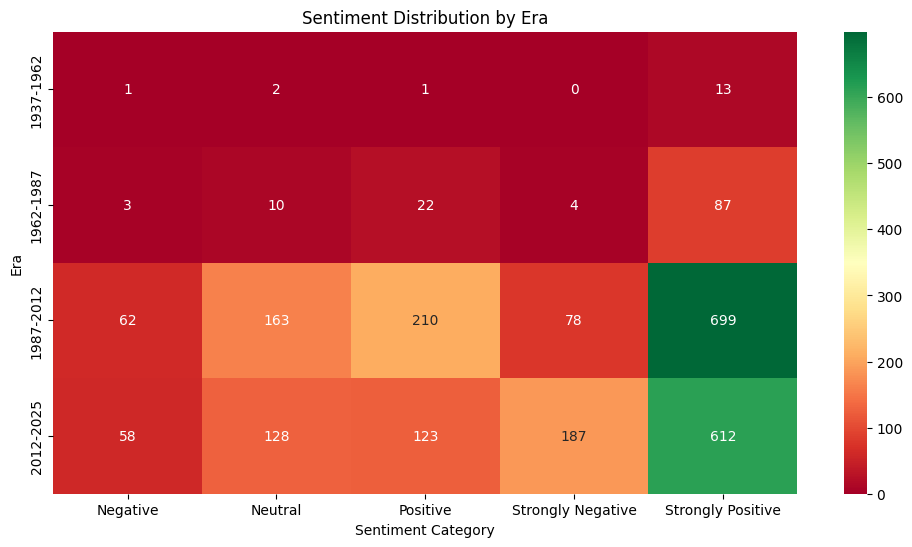

In [5]:
plt.figure(figsize=(12,6))
sns.heatmap(pd.crosstab(summary_with_sentiment_df['era'], summary_with_sentiment_df['sentiment_category']),
            annot=True, fmt="d", cmap="RdYlGn", cbar=True)

plt.title("Sentiment Distribution by Era")
plt.ylabel("Era")
plt.xlabel("Sentiment Category")
plt.show()


#### Area charts

In [12]:
colors = {
    'Strongly Negative': '#B22222',  # dark red
    'Negative': '#FFA500',           # orange
    'Neutral': '#FFD700',            # yellow
    'Positive': '#98FB98',           # light green
    'Strongly Positive': '#006400'   # dark green
}

<Figure size 1500x800 with 0 Axes>

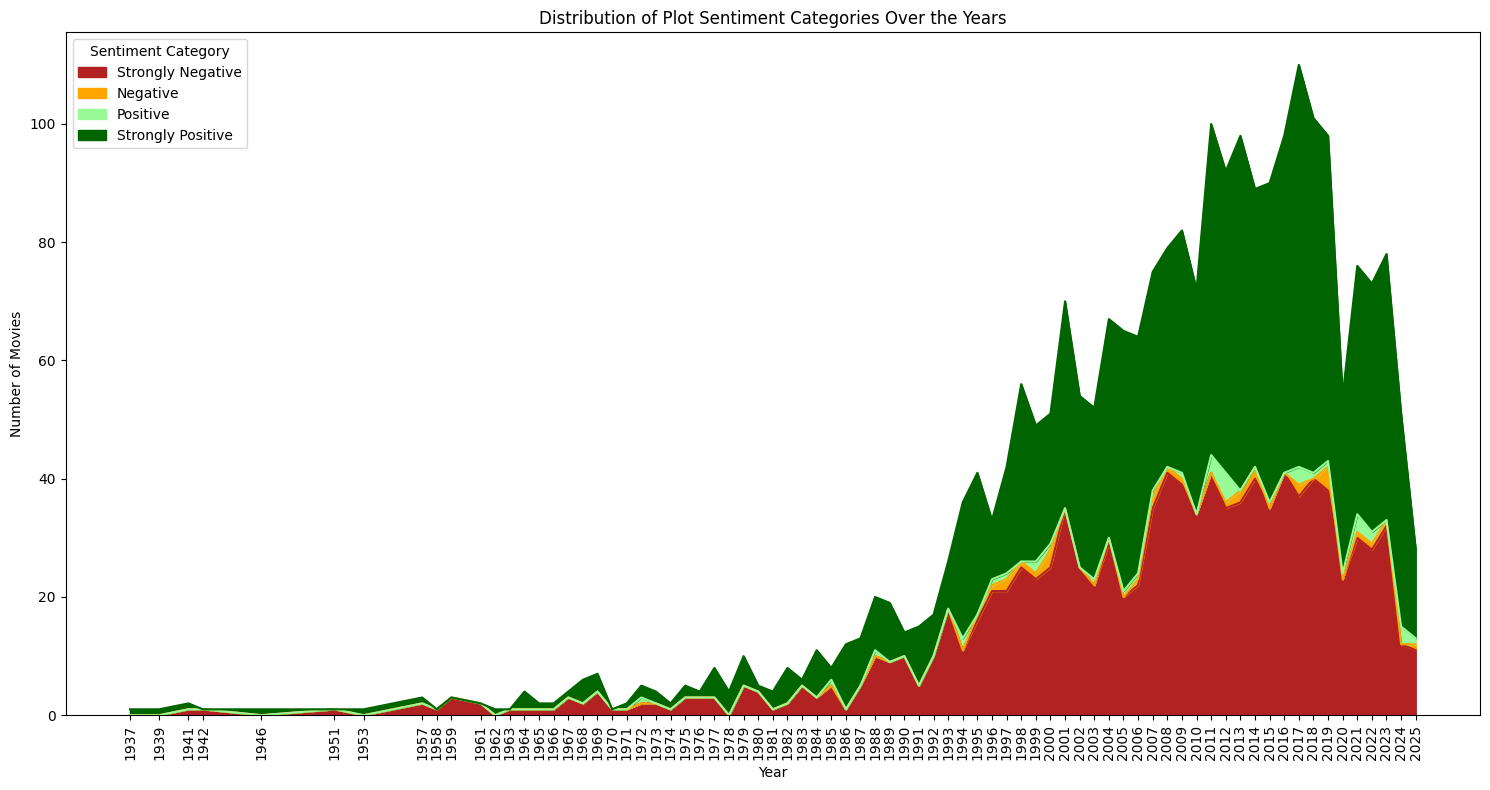

In [12]:
# Group by YEAR and PLOT SENTIMENT CATEGORY and count the occurrences
sentiment_by_year = summary_with_sentiment_df.groupby(['year', 'plot_sentiment_category']).size().unstack(fill_value=0)

sentiment_order = ['Strongly Negative', 'Negative', 'Positive', 'Strongly Positive'] # Removed 'Neutral'
sentiment_by_year = sentiment_by_year[sentiment_order]


# Create the stacked area chart
plt.figure(figsize=(15, 8))
ax = sentiment_by_year.plot(kind='area', stacked=True, color=[colors[col] for col in sentiment_order], figsize=(15, 8))

plt.title('Distribution of Plot Sentiment Categories Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Movies')

ax.set_xticks(sentiment_by_year.index)
plt.xticks(rotation=90)

plt.legend(title='Sentiment Category')
plt.tight_layout()
plt.show()

<Figure size 1500x800 with 0 Axes>

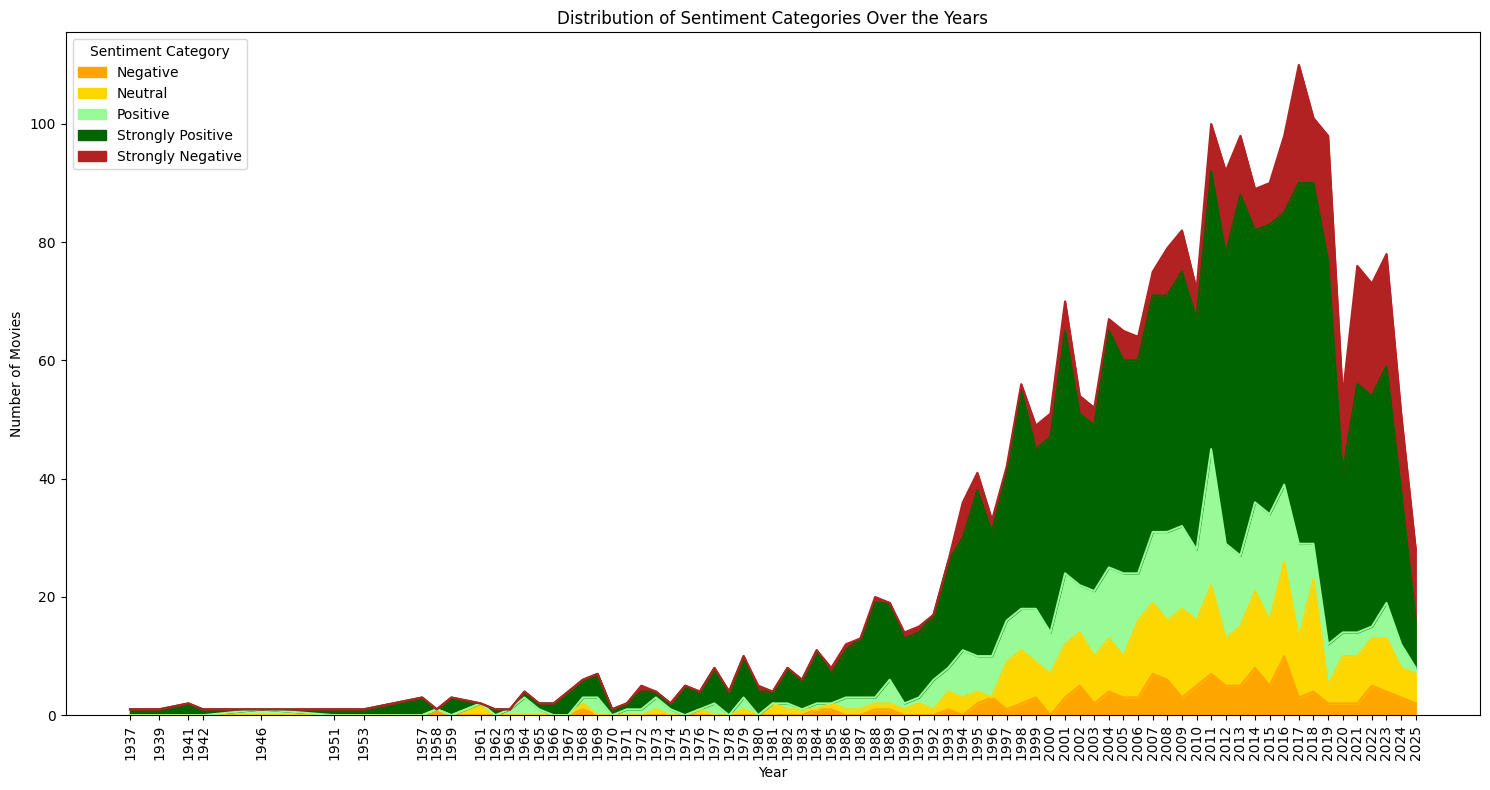

In [32]:
# Group by YEAR and SENTIMENT CATEGORY and count the occurrences
sentiment_by_year = summary_with_sentiment_df.groupby(['year', 'sentiment_category']).size().unstack(fill_value=0)

sentiment_order = ['Negative', 'Neutral', 'Positive', 'Strongly Positive', 'Strongly Negative'] # Removed 
sentiment_by_year = sentiment_by_year[sentiment_order]

# Create the stacked area chart
plt.figure(figsize=(15, 8))
ax = sentiment_by_year.plot(kind='area', stacked=True, color=[colors[col] for col in sentiment_order], figsize=(15, 8))

plt.title('Distribution of Sentiment Categories Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Movies')

ax.set_xticks(sentiment_by_year.index)
plt.xticks(rotation=90)

plt.legend(title='Sentiment Category')
plt.tight_layout()
plt.show()

<Figure size 1500x800 with 0 Axes>

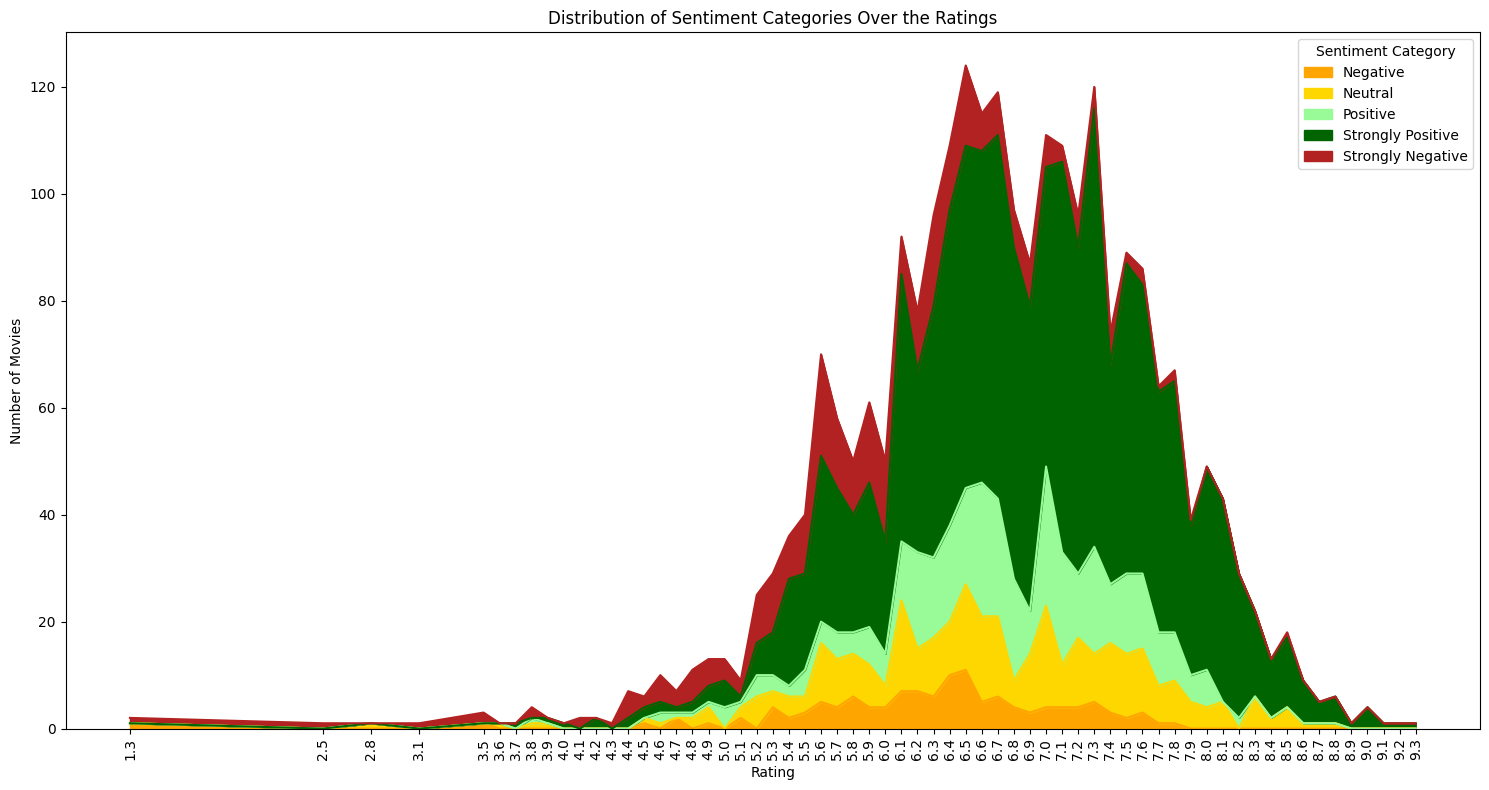

In [10]:
# Group by RATING and SENTIMENT CATEGORY and count the occurrences
sentiment_by_rating = summary_with_sentiment_df.groupby(['rating', 'sentiment_category']).size().unstack(fill_value=0)

sentiment_order = ['Negative', 'Neutral', 'Positive', 'Strongly Positive', 'Strongly Negative'] # Removed 
sentiment_by_rating = sentiment_by_rating[sentiment_order]

# Create the stacked area chart
plt.figure(figsize=(15, 8))
ax = sentiment_by_rating.plot(kind='area', stacked=True,color=[colors[col] for col in sentiment_order], figsize=(15, 8))

plt.title('Distribution of Sentiment Categories Over the Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Movies')

ax.set_xticks(sentiment_by_rating.index)
plt.xticks(rotation=90)

plt.legend(title='Sentiment Category')
plt.tight_layout()
plt.show()

<Figure size 1500x800 with 0 Axes>

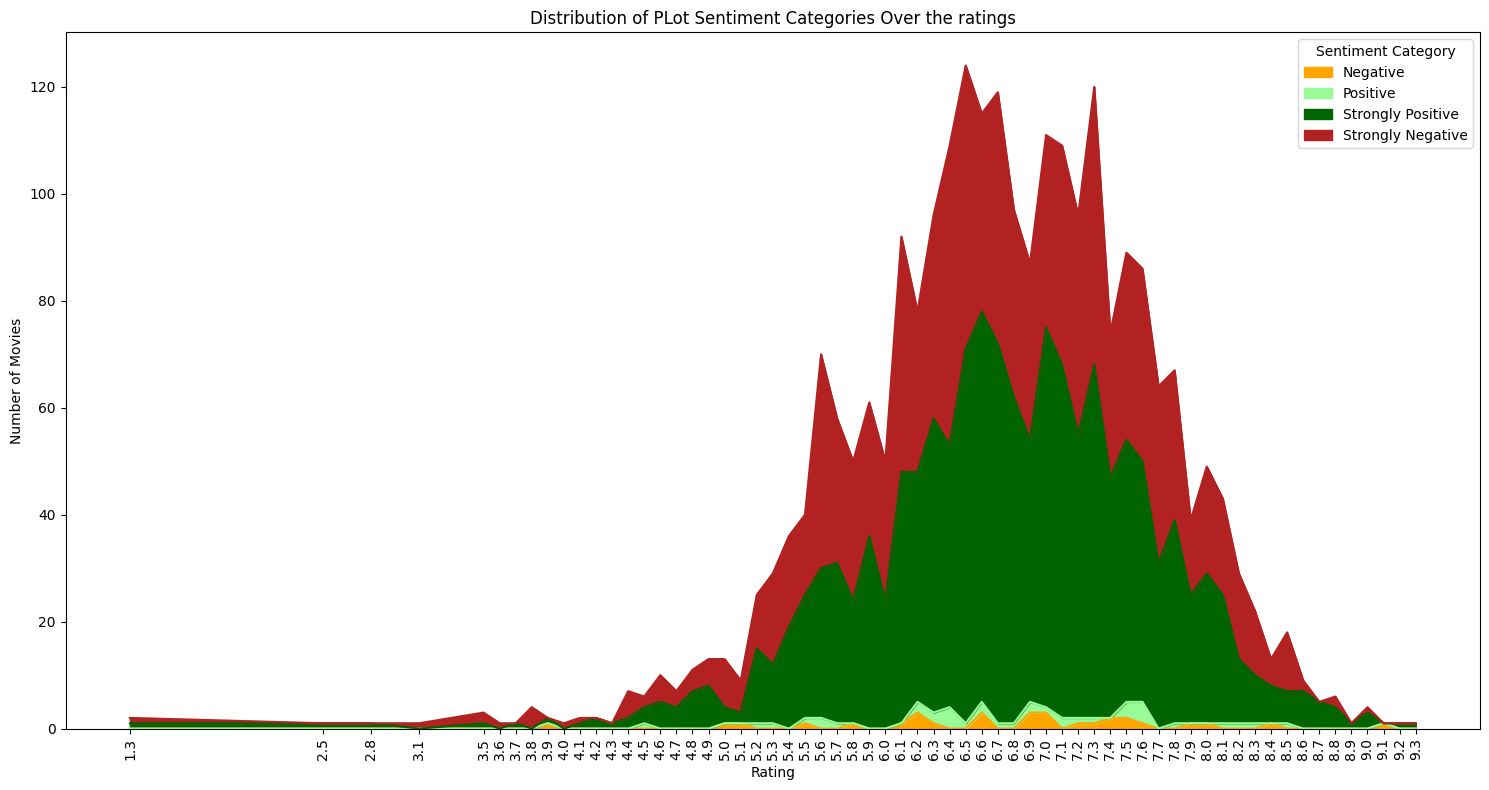

In [36]:
# Group by RATING and PLOT SENTIMENT CATEGORY and count the occurrences
sentiment_by_rating = summary_with_sentiment_df.groupby(['rating', 'plot_sentiment_category']).size().unstack(fill_value=0)

sentiment_order = ['Negative', 'Positive', 'Strongly Positive', 'Strongly Negative'] # Removed 'Neutral'
sentiment_by_rating = sentiment_by_rating[sentiment_order]

# Create the stacked area chart
plt.figure(figsize=(15, 8))
ax = sentiment_by_rating.plot(kind='area', stacked=True,color=[colors[col] for col in sentiment_order], figsize=(15, 8))

plt.title('Distribution of PLot Sentiment Categories Over the ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Movies')

ax.set_xticks(sentiment_by_rating.index)
plt.xticks(rotation=90)

plt.legend(title='Sentiment Category')
plt.tight_layout()
plt.show()

## ChatGPT

Prompt

I'll show you a pandas df in csv format
This df shows movies -- with title, year, plot, summary.
Based on this df create 6 emotional categories that can fit the plot. 
Please return the exact same df in .csv format, separated by ; and add an extra column with the emotional categories.
a line should look something like this: "title;year;emotional_category" "The Godfather;1972;[actual emotional_category value]"
Return nothing else but the lines of the semicolon separated table in raw text format

In [6]:
#import summary_df
summary_gpt_df = pd.read_csv('summary_with_emotions.csv', delimiter=';')

### Data cleaning

In [9]:
summary_gpt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2723 entries, 0 to 2722
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               2723 non-null   object 
 1   year                2502 non-null   float64
 2   rating              2722 non-null   float64
 3   plot                2718 non-null   object 
 4   summary             2711 non-null   object 
 5   emotional_category  2723 non-null   object 
dtypes: float64(2), object(4)
memory usage: 127.8+ KB


In [20]:
print(f"Total number of movies without year: {len(summary_gpt_df['title'][summary_gpt_df['year'] == 0])}")
print(f"Total number of movies with year null: {len(summary_gpt_df['title'][summary_gpt_df['year'].isnull()])}")
print(f"Total number of movies without rating: {len(summary_gpt_df['title'][summary_gpt_df['rating'].isnull()])}")
print(f"Total number of movies without plot: {len(summary_gpt_df['title'][summary_gpt_df['plot'].isnull()])}")
print(f"Total number of movies without summary: {len(summary_gpt_df['title'][summary_gpt_df['summary'].isnull()])}")
print(f"Total number of movies without title: {len(summary_gpt_df['title'][summary_gpt_df['title'].isnull()])}")

Total number of movies without year: 0
Total number of movies with year null: 221
Total number of movies without rating: 1
Total number of movies without plot: 5
Total number of movies without summary: 12
Total number of movies without title: 0


In [7]:
# Filter out rows where the year is 0
summary_gpt_df = summary_gpt_df[summary_gpt_df['year'] != 0]
summary_gpt_df = summary_gpt_df[summary_gpt_df['year'].isnull() == False]
summary_gpt_df = summary_gpt_df[summary_gpt_df['plot'].isnull() == False]
summary_gpt_df = summary_gpt_df[summary_gpt_df['summary'].isnull() == False]
print(len(summary_gpt_df))

2491


In [8]:
summary_gpt_df['title'] = summary_gpt_df['title'].astype(str)
summary_gpt_df['year'] = summary_gpt_df['year'].astype(int)
summary_gpt_df['rating'] = summary_gpt_df['rating'].astype(float)
summary_gpt_df['summary'] = summary_gpt_df['summary'].astype(str)
summary_gpt_df['plot'] = summary_gpt_df['plot'].astype(str)

### Sentiment analysis

Categories

#Cluster 1 → Mostly negative / tragic tones (loss, death, hardship).
#Cluster 2 → Mixed, leaning neutral (descriptive, factual).
#Cluster 3 → Positive 🎉 (hope, inspiration, love, uplifting endings).
#Cluster 4 → Mixed but slightly negative (conflict, struggle).
#Cluster 5 → Positive 🎉 (friendship, adventure, optimism).
#Cluster 6 → Strongly negative (violence, crime, despair).

In [9]:
# Define a mapping dictionary for the old and new names
rename_mapping = {
    'Category_1': 'Negative',
    'Category_2': 'Neutral',
    'Category_3': 'Positive',
    'Category_4': 'Negative',
    'Category_5': 'Positive',
    'Category_6': 'Strongly Negative',
}

# Rename the categories in the 'Category' column
summary_gpt_df['emotional_category'] = summary_gpt_df['emotional_category'].replace(rename_mapping)

#Cluster 1 → Mostly negative / tragic tones (loss, death, hardship).
#Cluster 2 → Mixed, leaning neutral (descriptive, factual).
#Cluster 3 → Positive 🎉 (hope, inspiration, love, uplifting endings).
#Cluster 4 → Mixed but slightly negative (conflict, struggle).
#Cluster 5 → Positive 🎉 (friendship, adventure, optimism).
#Cluster 6 → Strongly negative (violence, crime, despair).

In [10]:
# Show results
print(f"\nSummary sentiment distribution:")
print(summary_gpt_df['emotional_category'].value_counts())


Summary sentiment distribution:
emotional_category
Negative             861
Positive             721
Neutral              461
Strongly Negative    448
Name: count, dtype: int64


### Charts

<Figure size 1500x800 with 0 Axes>

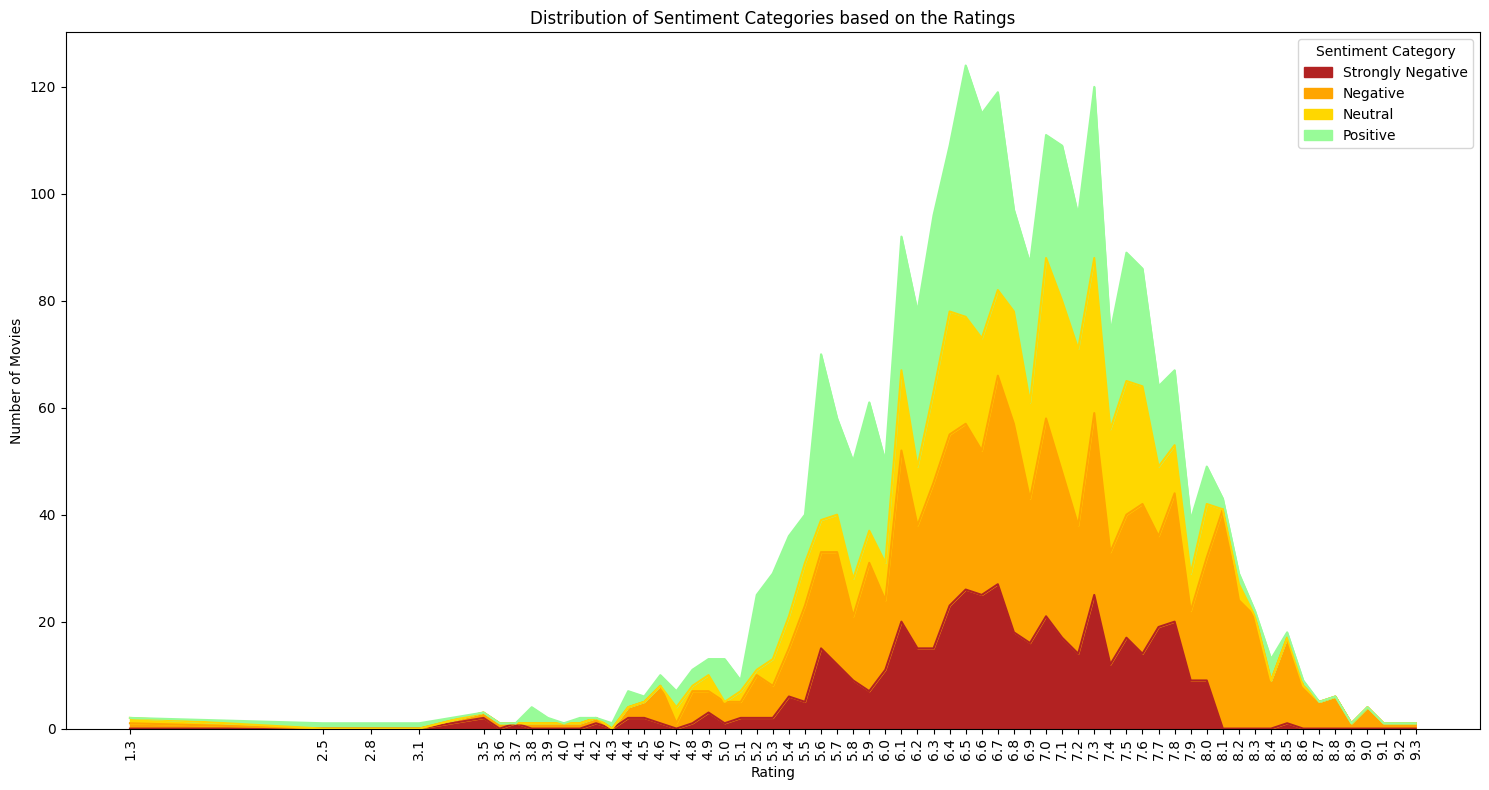

In [13]:
# Group by RATING and SENTIMENT CATEGORY and count the occurrences
sentiment_by_rating = summary_gpt_df.groupby(['rating', 'emotional_category']).size().unstack(fill_value=0)

sentiment_order = ['Strongly Negative', 'Negative', 'Neutral', 'Positive']
sentiment_by_rating = sentiment_by_rating[sentiment_order]

# Create the stacked area chart
plt.figure(figsize=(15, 8))
ax = sentiment_by_rating.plot(kind='area', stacked=True,color=[colors[col] for col in sentiment_order], figsize=(15, 8))

plt.title('Distribution of Sentiment Categories based on the Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Movies')

ax.set_xticks(sentiment_by_rating.index)
plt.xticks(rotation=90)

plt.legend(title='Sentiment Category')
plt.tight_layout()
plt.show()

<Figure size 1500x800 with 0 Axes>

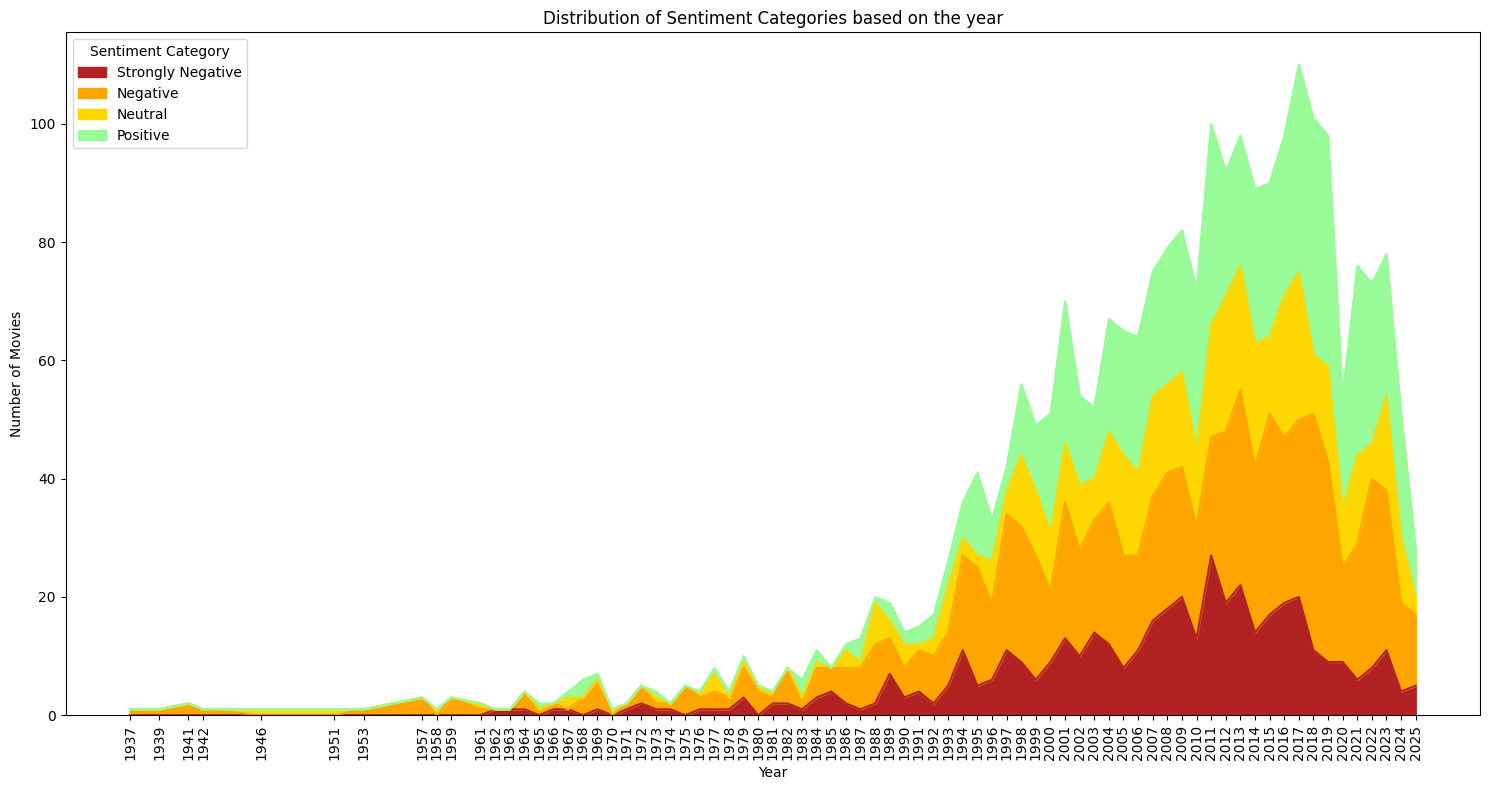

In [24]:
# Group by YEAR and SENTIMENT CATEGORY and count the occurrences
sentiment_by_year = summary_gpt_df.groupby(['year', 'emotional_category']).size().unstack(fill_value=0)

# Sort the columns to ensure consistent stacking order (optional but good practice)
# You can adjust the order of categories in this list if you prefer a different order
sentiment_order = ['Strongly Negative', 'Negative', 'Neutral', 'Positive']
sentiment_by_year = sentiment_by_year[sentiment_order]


# Create the stacked area chart
plt.figure(figsize=(15, 8))
ax = sentiment_by_year.plot(kind='area', stacked=True,color=[colors[col] for col in sentiment_order], figsize=(15, 8))

plt.title('Distribution of Sentiment Categories based on the year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')

# Set x-axis ticks to the years present in the grouped data
ax.set_xticks(sentiment_by_year.index)
plt.xticks(rotation=90)

plt.legend(title='Sentiment Category')
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

# Final results / comparison

In [22]:
# Sentiment % from summary
sentiment_pct = (
    summary_with_sentiment_df['sentiment_category']
    .value_counts(normalize=True) * 100
).round(2)

# Sentiment % from plot
plot_sentiment_pct = (
    summary_with_sentiment_df['plot_sentiment_category']
    .value_counts(normalize=True) * 100
).round(2)


gpt_sentiment_pct = (
    summary_gpt_df['emotional_category']
    .value_counts(normalize=True) * 100
).round(2)

In [ ]:
ordered_categories = [
    "Strongly Negative",
    "Negative",
    "Neutral",
    "Positive",
    "Strongly Positive"
]
# Union of all categories
all_categories = set(sentiment_pct.index) \
                 | set(plot_sentiment_pct.index) \
                 | set(gpt_sentiment_pct.index)

# Calculate raw counts
sentiment_counts = summary_with_sentiment_df['sentiment_category'].value_counts()
plot_sentiment_counts = summary_with_sentiment_df['plot_sentiment_category'].value_counts()
gpt_sentiment_counts = summary_gpt_df['emotional_category'].value_counts()

# Reindex all with the full set
sentiment_pct = sentiment_pct.reindex(ordered_categories, fill_value=0)
plot_sentiment_pct = plot_sentiment_pct.reindex(ordered_categories, fill_value=0)
gpt_sentiment_pct = gpt_sentiment_pct.reindex(ordered_categories, fill_value=0)

# Reindex counts as well
sentiment_counts = sentiment_counts.reindex(ordered_categories, fill_value=0)
plot_sentiment_counts = plot_sentiment_counts.reindex(ordered_categories, fill_value=0)
gpt_sentiment_counts = gpt_sentiment_counts.reindex(ordered_categories, fill_value=0)

# Combine into one DataFrame
combined_pct = pd.DataFrame({
    "sentiment_category": ordered_categories,
    "plot_percentage": plot_sentiment_pct.values,
    "summary_percentage": sentiment_pct.values,
    "gpt_percentage": gpt_sentiment_pct.values
})

for col in ["summary_percentage", "plot_percentage", "gpt_percentage"]:
    combined_pct[col] = (combined_pct[col]).astype(str) + '%'

# Raw counts table
combined_counts = pd.DataFrame({
    "sentiment_category": ordered_categories,
    "plot_count": plot_sentiment_counts.values,
    "summary_count": sentiment_counts.values,
    "gpt_count": gpt_sentiment_counts.values
})

In [33]:
print("🎯 SENTIMENT ANALYSIS RESULTS")
print("=" * 60)

print("\n📈 PERCENTAGE DISTRIBUTION")
print("-" * 40)
print(combined_pct.to_string(index=False))

print("\n📋 RAW COUNT DISTRIBUTION") 
print("-" * 40)
print(combined_counts.to_string(index=False))

print("\n📊 SUMMARY STATISTICS")
print("-" * 40)
print(f"📝 Total Summary Records: {combined_counts['summary_count'].sum():,}")
print(f"📖 Total Plot Records: {combined_counts['plot_count'].sum():,}")
print(f"🤖 Total GPT Records: {combined_counts['gpt_count'].sum():,}")

# Most common sentiment for each method
print(f"\n🏆 Most Common Sentiments:")
print(f"   Summary: {combined_counts.loc[combined_counts['summary_count'].idxmax(), 'sentiment_category']}")
print(f"   Plot: {combined_counts.loc[combined_counts['plot_count'].idxmax(), 'sentiment_category']}")  
print(f"   GPT: {combined_counts.loc[combined_counts['gpt_count'].idxmax(), 'sentiment_category']}")

🎯 SENTIMENT ANALYSIS RESULTS

📈 PERCENTAGE DISTRIBUTION
----------------------------------------
sentiment_category plot_percentage summary_percentage gpt_percentage
 Strongly Negative          42.39%             11.28%         17.98%
          Negative            1.2%              5.06%         34.56%
           Neutral            0.0%             12.36%         18.51%
          Positive           1.57%             14.33%         28.94%
 Strongly Positive          54.84%             56.97%           0.0%

📋 RAW COUNT DISTRIBUTION
----------------------------------------
sentiment_category  plot_count  summary_count  gpt_count
 Strongly Negative        1056            281        448
          Negative          30            126        861
           Neutral           0            308        461
          Positive          39            357        721
 Strongly Positive        1366           1419          0

📊 SUMMARY STATISTICS
----------------------------------------
📝 Total Summary R

# NOT IN USE (additional tryout codes)

In [11]:
#PULL THE INFORMATION FROM THE CARDS 1 BY 1

#THIS PART IS RUNNING FOR 81 seconds for 50 titles
#THIS PART IS RUNNING FOR 181 seconds for 100 titles
#THIS PART WOULD RUN FOR approximately 81 MINUTES FOR THE WHOLE LIST - 2723 TITLES (11 PAGES)

all_movies = []
headers = {'User-Agent': 'Mozilla/5.0'}

for url in only_url[:100]:
    current_movie = []
    current_movie_data = []
    response = requests.get(url, headers=headers)
    html = response.content
    soup = bs(html, "lxml")

    ########
    ## TITLE
    ########
    try:
        title_element = soup.find('h1', attrs={'data-testid': 'hero__pageTitle'})
        if title_element:
            title = title_element.get_text(strip=True)
            current_movie.append(title)
    except:
        print('no title found')

    ########
    ## YEAR
    ########
    try:
      year_div = soup.find('ul', class_="ipc-inline-list ipc-inline-list--show-dividers sc-cb6a22b2-2 aFhKV baseAlt baseAlt")
      year_next_level = year_div.find('li', class_="ipc-inline-list__item")
      year = year_next_level.find('a').get_text(strip=True)
      current_movie.append(year)
    except:
      print('no year found')

    ##########
    ## RATING
    #########
    try:
        rating_span = soup.find('span', class_="sc-4dc495c1-1 lbQcRY")
        rating = rating_span.get_text(strip=True) if rating_span else None
        current_movie.append(rating)
    except Exception as e:
        print(f'no rating found: {e}')

    #############
    ## SHORT PLOT
    #############
    try:
      plot = soup.find_all("span", class_="sc-bf30a0e-2 bRimta")
      current_movie.append(plot)
    except:
        print('no short plot found')

    #############
    ## AI SUMMARY
    #############
    try:
      ai_summary = soup.find_all('div', class_='ipc-html-content-inner-div')
      current_movie.append(ai_summary)
    except:
        print('no AI summary found')

    ############################
    ## PREPARING THE NESTED LIST
    ############################
    #TITLE
    try:
        current_movie_data.append(current_movie[0])
    except:
        current_movie_data.append(0)
    
    #YEAR
    try:
        current_movie_data.append(current_movie[1])
    except:
        current_movie_data.append(0)
    
    #RATING
    try:
        current_movie_data.append(current_movie[2])
    except:
        current_movie_data.append(0)
    
    #plot
    try:
        current_movie_data.append(current_movie[3])
    except:
        current_movie_data.append(0)
    
    #summary
    try:
        current_movie_data.append(current_movie[4])
    except:
        current_movie_data.append(0)

    all_movies.append(current_movie_data)

In [27]:
# Count the occurrences of each sentiment category
plot_sentiment_category_counts = summary_with_sentiment_df['plot_sentiment_category'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 7))
plot_sentiment_category_counts.plot(kind='bar')
plt.title('Distribution of Plot Sentiment Categories (5 Categories)')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

NameError: name 'summary_with_sentiment_df' is not defined

In [19]:
#PLOT
#RUNNING FOR 150 seconds FOR 2700 TITLES
sentiment_plot = []
# Define the maximum sequence length for the model
max_len = sentiment_analyzer.model.config.max_position_embeddings

for plot in summary_df['plot']:
    # Truncate the plot to the maximum length
    truncated_plot = plot[:max_len]
    result = sentiment_analyzer(truncated_plot)
    sentiment_plot.append(result[0])

summary_df['plot_sent'] = sentiment_plot

In [ ]:
sentiment_labels = summary_df['sentiment'].apply(lambda x: x['label'])
sentiment_counts = sentiment_labels.value_counts()

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Number of Movies')
plt.xticks(rotation=0)
plt.show()

In [20]:
#SUMMARY
#RUNNING FOR 347 SECONDS FOR 2700 TITLES

sentiments = []
# Define the maximum sequence length for the model
max_len = sentiment_analyzer.model.config.max_position_embeddings

for summary in summary_df['summary']:
    # Truncate the summary to the maximum length
    truncated_summary = summary[:max_len]
    result = sentiment_analyzer(truncated_summary)
    sentiments.append(result[0])

summary_df['sentiment'] = sentiments

In [ ]:
plot_sentiment_labels = summary_df['sentiment'].apply(lambda x: x['label'])
plot_sentiment_counts = plot_sentiment_labels.value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
plot_sentiment_counts.plot(kind='bar')
plt.title('Distribution of Summary Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Number of Movies')
plt.xticks(rotation=0)
plt.show()